<a href="https://colab.research.google.com/github/Aleksa21052001/my-projects/blob/main/Pneumonia_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to build a convolutional neural network (CNN) using TensorFlow to categorize chest X-ray images.

The dataset contains two categories of images: normal and pneumonia. It is organized into three splits: a training dataset (used to train the model), a validation dataset (used during training to tune hyperparameters and monitor performance), and a test dataset (used after training to evaluate the final performance on unseen data).

 Each split is structured into two folders: one with pneumonia images and one with normal images (ground truth).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, confusion_matrix
import os
import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

In [3]:
# === DATASET ACCESS BLOCK: RUN THIS BLOCK TO DOWNLOAD DATASET ===
# Function to check if dataset is already extracted
def dataset_ready():
    return os.path.exists("chest_xray/train") and os.path.exists("chest_xray/test") and os.path.exists("chest_xray/val")

# Only download if not already present
if not dataset_ready():
    print("Accessing dataset from shared Google Drive (this may take a few minutes)...")

    start_time = time.time()

    # Install gdown for better Google Drive large file handling
    !pip install -q gdown

    # Download directly from your shared Google Drive link
    !gdown --id 1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91- -O chest_xray.zip

    print(f"Download completed in {(time.time() - start_time)/60:.1f} minutes. Extracting files...")

    # Extract the dataset
    !unzip -q chest_xray.zip

    # Remove macOS placeholder files if present
    !find chest_xray/__MACOSX -delete

    print(f"Setup completed in {(time.time() - start_time)/60:.1f} minutes total.")
else:
    print("Dataset already prepared!")

Accessing dataset from shared Google Drive (this may take a few minutes)...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91-
From (redirected): https://drive.google.com/uc?id=1xTqvghtgVgLDrzEiS0ZNL6-Cx26jk91-&confirm=t&uuid=acfa1092-155d-4f9e-a1de-5d06f72ede30
To: /content/chest_xray.zip
100% 1.24G/1.24G [00:19<00:00, 64.8MB/s]
Download completed in 0.5 minutes. Extracting files...
Setup completed in 0.7 minutes total.


### Loading and Preparing the Training and Test Datasets

In this step, we load the X-ray images from folders using `image_dataset_from_directory`.  
The function automatically recognizes the two classes (normal and pneumonia) from the subfolders and assigns labels (0 and 1).  

- **Training dataset:** images are loaded and automatically divided into batches, ready for training the CNN model.  
- **Test dataset:** images are loaded separately and will be used **only for final evaluation** of the trained model, without affecting training or validation.


In [4]:
## Folder sa originalnim NORMAL slikama
normal_folder = "chest_xray/train/NORMAL"

# Broj augmentovanih slika po originalu
augment_per_image = 1  # postavi koliko novih slika želiš po originalu

## ImageDataGenerator za augmentaciju
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Generiši i sačuvaj augmentovane slike nazad u folder
# Lista svih slika u NORMAL folderu
image_files = [f for f in os.listdir(normal_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_files:
    img_path = os.path.join(normal_folder, img_name)

    # Učitaj i skaliraj sliku
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # dodaj batch dimenziju

    # Generiši augmentovane slike
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=normal_folder, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= augment_per_image:
            break


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory='chest_xray/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True   # important!
)

Found 6475 files belonging to 2 classes.


In [6]:
test_ds = image_dataset_from_directory(
    directory='chest_xray/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True   # important!
)

Found 624 files belonging to 2 classes.


In [7]:
val_ds = image_dataset_from_directory(
    directory='chest_xray/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 16 files belonging to 2 classes.


### Visualizing Sample Images from the Training Dataset

In this step, we take a single batch from the training dataset and randomly select three images to visualize.  
Each selected image is displayed with its corresponding label (normal or pneumonia).

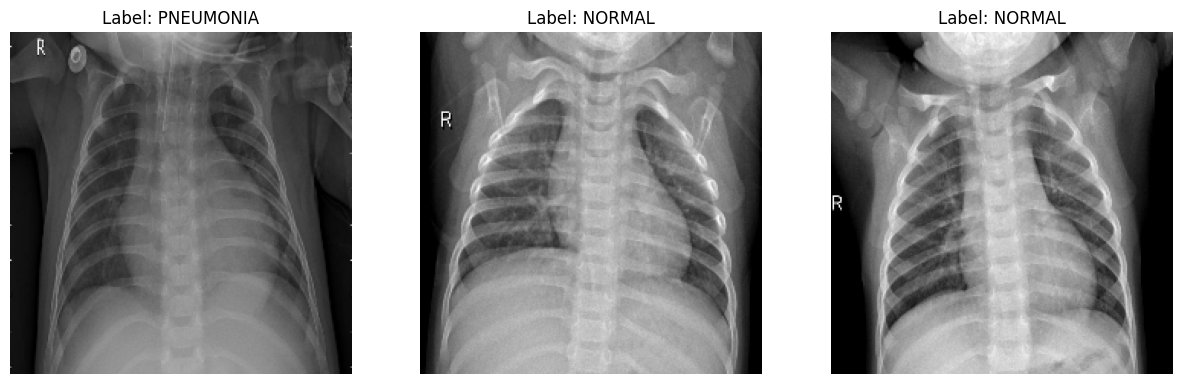

In [8]:
for images, labels in train_ds.take(1):  # uzimamo jedan batch
    batch_size = images.shape[0]        # koliko slika u batchu
    random_indexes = random.sample(range(batch_size), 3)  # 3 nasumična indeksa, bez ponavljanja

    plt.figure(figsize=(15, 5))  # veća figura za 3 slike

    # idx je vrednost
    for i, idx in enumerate(random_indexes):
        plt.subplot(1, 3, i + 1)  # 1 red, 3 kolone, pozicija i+1
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title(f"Label: {train_ds.class_names[labels[idx]]}")
        plt.axis("off")

    plt.show()

### Splitting Training Dataset for Training and Validation

Since the original validation set is too small (16 images), we will not use it.  
Instead, we will split the original training dataset (5216 images) into **training and validation sets**.

In [9]:
total_train_images = 0
for images, labels in train_ds:
    total_train_images += images.shape[0]
print("Total images in train_ds before split:", total_train_images)

Total images in train_ds before split: 6475


In [10]:
# Prethodno učitan originalni train dataset
original_train_ds = train_ds

# Broj batch-eva
train_batches = len(original_train_ds)
train_split = int(train_batches * 0.8)

# 80% za trening, 20% za validaciju
train_ds = original_train_ds.take(train_split)   # train_ds sada znači trening set
validation_ds = original_train_ds.skip(train_split)  # validation set


In [11]:
total_train_images = 0
for images, labels in train_ds:
    total_train_images += images.shape[0]
print("Total images in train_ds after split:", total_train_images)

Total images in train_ds after split: 5184


#### Class distribution visualization

In [12]:
count_0 = 0
count_1 = 0

for images_batch, labels in train_ds:
  labels_np = labels.numpy()        # konvertuje tensor u numpy array
  count_0 += np.sum(labels_np == 0) # prebrojava koliko ima labela 0 u batchu
  count_1 += np.sum(labels_np == 1) # prebrojava koliko ima labela 1 u batchu


print ('0: ', count_0)
print ('1: ', count_1)
# (images_batch.shape)  - (32, 224, 224, 3)
# (labels.shape)  - (32,)

0:  2073
1:  3111


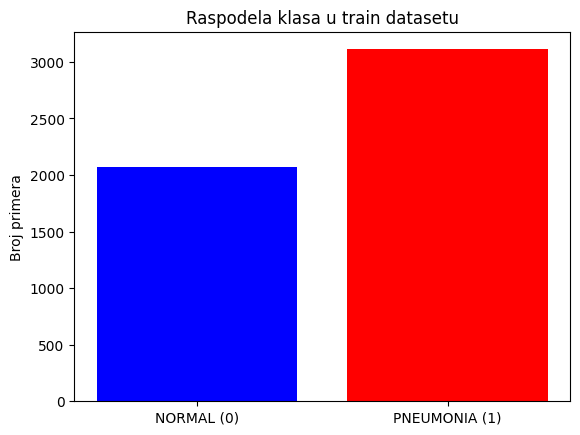

In [13]:
labels = ['NORMAL (0)', 'PNEUMONIA (1)']
counts = [count_0, count_1]

plt.bar(labels, counts, color=['blue', 'red'])
plt.ylabel('Broj primera')
plt.title('Raspodela klasa u train datasetu')
plt.show()

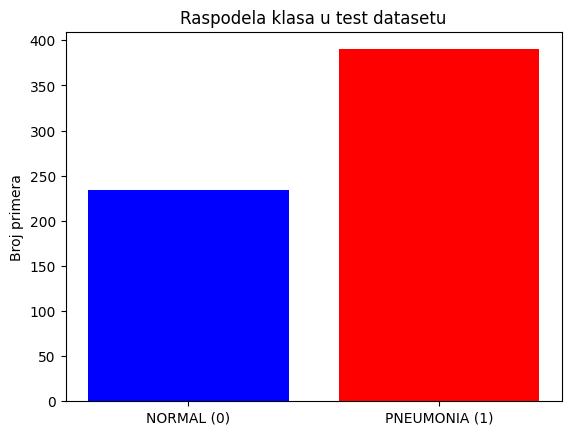

In [14]:
count_0 = 0
count_1 = 0

for images_batch, labels in test_ds:

  labels_np = labels.numpy()        # konvertuje tensor u numpy array
  count_0 += np.sum(labels_np == 0) # prebrojava koliko ima labela 0 u batchu
  count_1 += np.sum(labels_np == 1) # prebrojava koliko ima labela 1 u batchu

labels = ['NORMAL (0)', 'PNEUMONIA (1)']
counts = [count_0, count_1]

plt.bar(labels, counts, color=['blue', 'red'])
plt.ylabel('Broj primera')
plt.title('Raspodela klasa u test datasetu')
plt.show()

### Image Normalization and Augmentation

In this step, we preprocess the training images to improve CNN performance.  
- **Image normalization:** Pixel values are rescaled from 0–255 to 0–1, which helps the model train faster and more stably.  
- **Image augmentation:** Various random transformations (horizontal flip, small rotation, zoom) are applied to the training images to make the model more robust and reduce overfitting.


In [15]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)) # Svaki element train_ds je tuple (images_batch, labels_batch)
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [16]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


#### Model Building

In [17]:
import tensorflow as tf

model = tf.keras.Sequential()

# Prvi Conv blok
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))

# Drugi Conv blok
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))

# Treći Conv blok (manje filtera nego u originalu)
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(2,2))

# Flatten i Dense slojevi
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

# Izlazni sloj
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Kompajliranje
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 54, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,986,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009,697 (11.48 MB)

 Trainable params: 3,009,697 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.applications import MobileNetV2

# Bazni model (pretreniran na ImageNet)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Zamrzni ga za početak

# Dodaj klasifikator na vrh
transfer_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

transfer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


 #### Training and Evaluation Framework

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definišemo callback-ove
early_stop = EarlyStopping(
    monitor='val_loss',      # pratimo validacioni gubitak
    patience=5,              # ako 5 epoha nema poboljšanja -> prekida
    restore_best_weights=True # vrati najbolje težine
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # pratimo validacioni gubitak
    factor=0.2,           # smanji LR na 20% trenutne vrednosti
    patience=3,           # čekaj 3 epohe bez poboljšanja pre smanjenja
    min_lr=1e-6           # minimalni learning rate
)

history_custom je objekat klase History koji Keras vraća kada pozoveš model.fit().

U njemu Keras čuva sve metrike tokom treniranja, za svaki epoch, kako za trening, tako i za validaciju (ako si prosledio validation_data).


In [20]:
# Treniranje sa callback-ovima
history_custom = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=8,
    callbacks=[early_stop, reduce_lr],  # dodali callback-ove
    verbose=1
)

Epoch 1/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 121s 688ms/step - accuracy: 0.5663 - loss: 0.7897 - val_accuracy: 0.6150 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 2/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 122s 611ms/step - accuracy: 0.7083 - loss: 0.5430 - val_accuracy: 0.8559 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 3/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 112s 690ms/step - accuracy: 0.7906 - loss: 0.4383 - val_accuracy: 0.8149 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 4/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 112s 691ms/step - accuracy: 0.8108 - loss: 0.4091 - val_accuracy: 0.8885 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 5/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 141s 684ms/step - accuracy: 0.8394 - loss: 0.3705 - val_accuracy: 0.8947 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 6/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 99s 612ms/step - accuracy: 0.8480 - loss: 0.3645 - val_accuracy: 0.8923 - val_loss: 0.2905 - learning_rate: 0.0010
Epoch 7/8
162/162 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.85

In [21]:
# Custom CNN
test_loss_cnn, test_acc_cnn = model.evaluate(test_ds)
print(f"Custom CNN - Test Loss: {test_loss_cnn:.4f}")
print(f"Custom CNN - Test Accuracy: {test_acc_cnn:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8012 - loss: 0.4043
Custom CNN - Test Loss: 0.3906
Custom CNN - Test Accuracy: 0.8173


In [22]:
# Transfer learning model

history_transfer = transfer_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=7
)


Epoch 1/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 128s 691ms/step - accuracy: 0.6932 - loss: 0.5759 - val_accuracy: 0.8885 - val_loss: 0.2520
Epoch 2/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 112s 692ms/step - accuracy: 0.8830 - loss: 0.2762 - val_accuracy: 0.8505 - val_loss: 0.3206
Epoch 3/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 141s 689ms/step - accuracy: 0.9119 - loss: 0.2266 - val_accuracy: 0.8892 - val_loss: 0.2518
Epoch 4/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 141s 683ms/step - accuracy: 0.9143 - loss: 0.2032 - val_accuracy: 0.9202 - val_loss: 0.2051
Epoch 5/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 99s 610ms/step - accuracy: 0.9173 - loss: 0.2030 - val_accuracy: 0.9280 - val_loss: 0.1923
Epoch 6/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 142s 611ms/step - accuracy: 0.9252 - loss: 0.1796 - val_accuracy: 0.9094 - val_loss: 0.2197
Epoch 7/7
162/162 ━━━━━━━━━━━━━━━━━━━━ 155s 691ms/step - accuracy: 0.9286 - loss: 0.1787 - val_accuracy: 0.9016 - val_loss: 0.2451


In [23]:
# Evaluacija transfer learning modela na test setu

test_loss_transfer, test_acc_transfer = transfer_model.evaluate(test_ds)
print("Transfer Model - Test Loss:", test_loss_transfer)
print("Transfer Model - Test Accuracy:", test_acc_transfer)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 655ms/step - accuracy: 0.7480 - loss: 0.6915
Transfer Model - Test Loss: 0.6763496994972229
Transfer Model - Test Accuracy: 0.7467948794364929


#### Vizualization

In [24]:
# 1. Plot accuracy and loss curves
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss curves.
    """
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


# 2. Confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Creates a confusion matrix visualization using seaborn heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

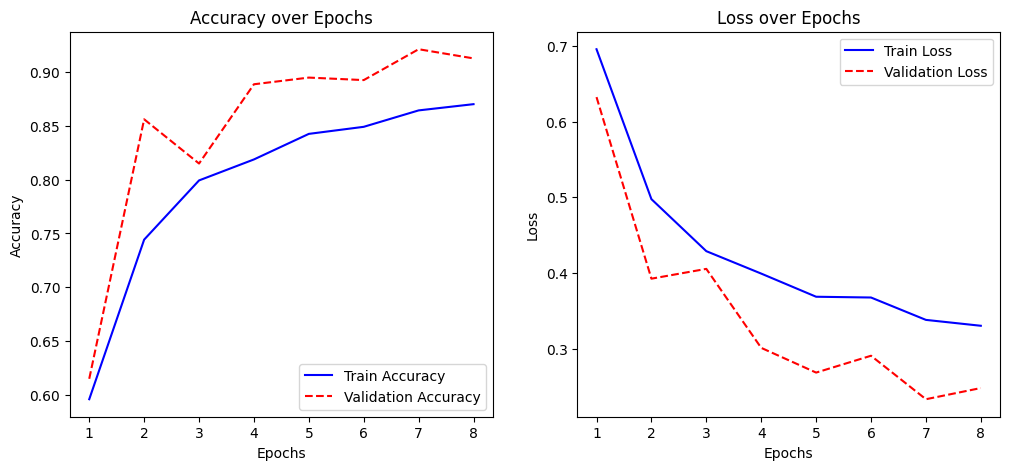

In [25]:
# Za tvoj custom CNN
plot_training_history(history_custom)


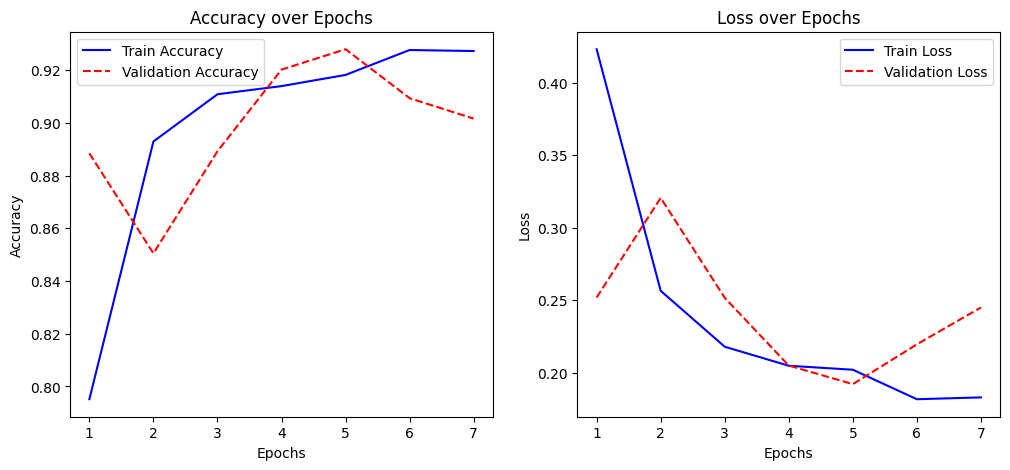

In [26]:
# Za transfer learning model
plot_training_history(history_transfer)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step


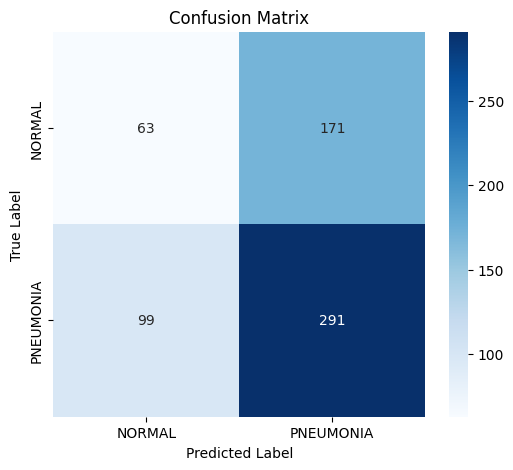


Classification Report:
              precision    recall  f1-score   support

      Normal       0.39      0.27      0.32       234
   Pneumonia       0.63      0.75      0.68       390

    accuracy                           0.57       624
   macro avg       0.51      0.51      0.50       624
weighted avg       0.54      0.57      0.55       624



In [27]:
# --- Za običan CNN model ---

# Pripremi stvarne i predviđene klase
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)           # verovatnoće
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # binarna predikcija

class_names = ['NORMAL', 'PNEUMONIA']

# Plotaćemo confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Classification report
report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'])
print("\nClassification Report:")
print(report)



20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step


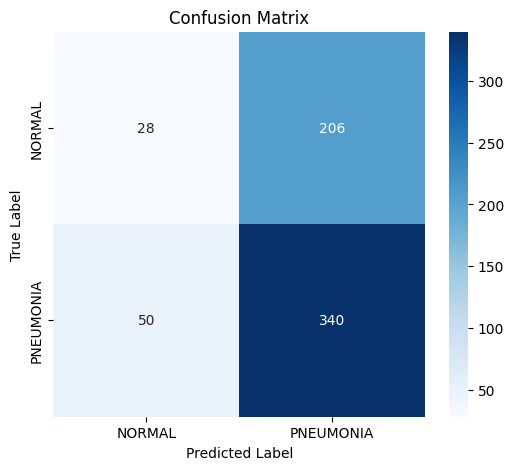


Classification Report:
              precision    recall  f1-score   support

      Normal       0.36      0.12      0.18       234
   Pneumonia       0.62      0.87      0.73       390

    accuracy                           0.59       624
   macro avg       0.49      0.50      0.45       624
weighted avg       0.52      0.59      0.52       624



In [28]:
# --- Za transfer learning model ---

# Pripremi stvarne klase i predviđene klase
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = transfer_model.predict(test_ds)             # verovatnoće
y_pred = (y_pred_prob > 0.5).astype(int).flatten()        # binarna predikcija

class_names = ['NORMAL', 'PNEUMONIA']

# Prikaži confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Classification report
report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'])
print("\nClassification Report:")
print(report)




#### Class weights (ponderi klasa)

Keras fit funkcija omogućava dodeljivanje veće težine manjinskoj klasi:

In [29]:
class_weights = {0: 3.0, 1: 1.0}  # NORMAL 3x teža
model.fit(train_ds, validation_data=validation_ds,
          epochs=6, class_weight=class_weights)

Epoch 1/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 116s 680ms/step - accuracy: 0.8398 - loss: 0.6228 - val_accuracy: 0.8056 - val_loss: 0.4092
Epoch 2/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 138s 689ms/step - accuracy: 0.8365 - loss: 0.5532 - val_accuracy: 0.8497 - val_loss: 0.3290
Epoch 3/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 143s 697ms/step - accuracy: 0.8372 - loss: 0.5319 - val_accuracy: 0.9078 - val_loss: 0.2646
Epoch 4/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 113s 697ms/step - accuracy: 0.8653 - loss: 0.4522 - val_accuracy: 0.9163 - val_loss: 0.2343
Epoch 5/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 112s 691ms/step - accuracy: 0.9012 - loss: 0.4082 - val_accuracy: 0.9101 - val_loss: 0.2473
Epoch 6/6
162/162 ━━━━━━━━━━━━━━━━━━━━ 112s 690ms/step - accuracy: 0.8915 - loss: 0.4045 - val_accuracy: 0.9187 - val_loss: 0.2101


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step


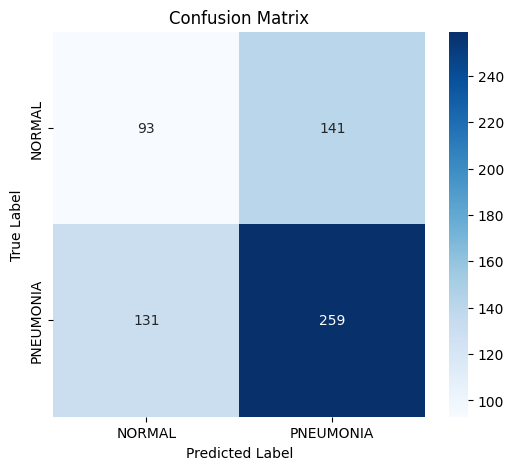


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.42      0.40      0.41       234
   PNEUMONIA       0.65      0.66      0.66       390

    accuracy                           0.56       624
   macro avg       0.53      0.53      0.53       624
weighted avg       0.56      0.56      0.56       624

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.8705 - loss: 0.3912
Test Loss: 0.3860
Test Accuracy: 0.8558


In [31]:
# 1. Pripremi stvarne klase (y_true) iz test seta
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# 2. Predikcija verovatnoća sa modelom
y_pred_prob = model.predict(test_ds)

# 3. Binarna klasifikacija (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 4. Definiši imena klasa
class_names = ['NORMAL', 'PNEUMONIA']

# 5. Prikaz konfuzione matrice
plot_confusion_matrix(y_true, y_pred, class_names)

# 6. Ispis Classification Report sa precision, recall, f1-score
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# 7. Opcionalno: evaluacija modela na test setu
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
